In [1]:
'''
Available methods are the followings:
[1] CalibatorEvaluation
[2] cal_score
[3] ClassWeights
[4] get_classweights

Authors: Danusorn Sitdhirasdr <danusorn.si@gmail.com>
versionadded:: 10-12-2021

'''
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.transforms as transforms
import matplotlib.ticker as ticker
import collections

plt.rcParams.update({'font.family':'sans-serif'})
plt.rcParams.update({'font.sans-serif':'Hiragino Sans GB'})
plt.rc('axes', unicode_minus=False)

__all__ = ["CalibatorEvaluation",
           "cal_score",
           "ClassWeights",
           "get_classweights"]

In [2]:
class CalibatorEvaluation():
    
    '''
    Evaluate calibrated probailities against target, in order to
    obtain more accurate probabilities. This method requires 
    grouping and validation of bin edges.
    
    Parameters
    ----------
    bins : sequence of int, default=range(2,10)
        Sequence of monotonically increasing int. Each of items 
        is used as starting number of bins.
        
    equal_width : bool, default=True
        If True, it uses equal-width binning, otherwise equal-
        sample binning is used instead.

    monotonic : bool, default=True
        If True, bins will be collspsed until number of targets 
        is either monotonically increasing or decreasing pattern.
        
    Attributes
    ----------
    result : dict
        Dictionary of output from <Calibration_base>, where key
        is number of iterations.

    r2 : list of float 
        R-Squared as per iteration.

    gini : list of float
        Gini Impurity as per iteration
        
    '''
    def __init__(self, bins=range(2,10), equal_width=True, 
                 monotonic=True):
        
        self.bins = bins
        self.equal_width = equal_width
        self.monotonic = monotonic
        
    def fit(self, y_train, y_test):
        
        '''
        Fit model.
        
        Parameters
        ----------
        y_train : tuple(y_true, y_proba) 
            Tuple of true labels of train dataset and corresponding
            calibrated probilities from estimator. 

        y_test : tuple(y_true, y_proba) 
            Tuple of true labels of test dataset and corresponding 
            calibrated probilities from estimator. 
        
        Attributes
        ----------
        result : dict
            Dictionary of output from `Calibrator_base`, where key
            is number of iterations.
            
        r2 : list of float 
            R-Squared as per iteration.
            
        gini : list of float
            Gini Impurity as per iteration
   
        '''
        # Initialize parameters
        self.result = dict()
        kwds = {"equal_width": self.equal_width}
        self.r2   = {"train":[], "test":[]}
        self.gini = {"train":[], "test":[]}
        Result = collections.namedtuple("Calibr", ["train",'test'])
        
        for (n, bins) in enumerate(self.bins):
            
            kwds.update({"bins" : bins, "monotonic" : self.monotonic})
            res_train = Calibrator_base(*y_train, **kwds)
            kwds.update({"bins" : res_train.bin_edges, "monotonic" : False})
            res_test  = Calibrator_base(*y_test, **kwds)
            
            self.result[n] = Result(*(res_train, res_test))
            for m in ["r2", "gini"]:
                getattr(self, m)["train"] += [getattr(res_train, m)]
                getattr(self, m)["test"]  += [getattr(res_test,  m)]
            
        return self

    def plotting_hist(self, n_iter=0, use_train=True, ax=None, colors=None, 
                      tight_layout=True, decimal=0, bar_kwds=None):
        
        '''
        Histogram between nth iteration and actual values.

        Parameters
        ----------
        n_iter : int, default=0
            Iteration index.

        use_train : bool, default=True
            If True, it uses result from train dataset, otherwisen test 
            dataset.

        ax : Matplotlib axis object, default=None
            Predefined Matplotlib axis. If None, `ax` is created with 
            default figsize.

        colors : list of color-hex, default=None
            Number of color-hex must be greater than or equal to 2. If 
            None, it uses default colors from Matplotlib. This overrides
            `bar_kwds`.

        tight_layout : bool, default=True
            If True, it adjusts the padding between and around subplots 
            i.e. plt.tight_layout().

        decimal : int, default=0
            Decimal places for annotation of % targets.

        bar_kwds : keywords, default=None
            Keyword arguments to be passed to `ax.bar`.

        Returns
        -------
        ax : Matplotlib axis object


        '''
        ax = histogram_base(self, n_iter=n_iter, use_train=use_train, 
                            ax=ax, colors=colors, tight_layout=tight_layout, 
                            decimal=decimal, bar_kwds=bar_kwds)
        return ax
    
    def plotting_reliability(self, n_iter=0, use_train=True, ax=None, 
                             colors=None, tight_layout=True, 
                             calibrate_kwds=None, estimate_kwds=None):
        
        '''
        Plot calibarated probabilities both train and test along with 
        actual percentage of targets (reliability curve).

        Parameters
        ----------
        n_iter : int, default=0
            Iteration index.

        use_train : bool, default=True
            If True, it uses result from train dataset, otherwise test 
            dataset.

        ax : Matplotlib axis object, default=None
            Predefined Matplotlib axis. If None, `ax` is created with 
            default figsize.

        colors : list of color-hex, default=None
            Number of color-hex must be greater than 2. If None, it uses 
            default colors from Matplotlib.

        tight_layout : bool, default=True
            If True, it adjusts the padding between and around subplots 
            i.e. plt.tight_layout().

        calibrate_kwds : keywords, default=None
            Keyword arguments of "Perfectly calibrated" to be passed to 
            `ax.plot`.

        estimate_kwds : keywords, default=None
            Keyword arguments of "Mean estimate" to be passed to `ax.plot`.

        Returns
        -------
        ax : Matplotlib axis object

        '''
        return reliability_base(self, n_iter=n_iter, use_train=use_train, 
                                ax=ax, colors=colors, tight_layout=tight_layout, 
                                calibrate_kwds=calibrate_kwds, 
                                estimate_kwds=estimate_kwds)
    
    def plotting_metric(self, metric="gini", ax=None, colors=None, 
                        tight_layout=True, plot_kwds=None):
        
        '''
        Plot evaluation metric.

        Parameters
        ----------
        metric: {"r2", "gini"}, default="gini"
            Evaluation metric.

        ax : Matplotlib axis object, default=None
            Predefined Matplotlib axis. If None, `ax` is created with 
            default figsize.

        colors : list of color-hex, default=None
            Number of color-hex must be greater than 2. If None, it uses 
            default colors from Matplotlib.

        tight_layout : bool, default=True
            If True, it adjusts the padding between and around subplots 
            i.e. plt.tight_layout().

        plot_kwds : keywords, default=None
            Keyword arguments to be passed to `ax.plot`.

        Returns
        -------
        ax : Matplotlib axis object

        '''
        return metric_base(self, metric=metric, ax=ax, colors=colors, 
                           tight_layout=tight_layout, plot_kwds=plot_kwds)

In [3]:
def metric_base(calibrator, metric="gini", ax=None, colors=None, 
                tight_layout=True, plot_kwds=None):
   
    '''
    Plot evaluation metric.

    Parameters
    ----------
    calibrator : class object
        Fitted `CalibatorEvaluation` object.

    metric: {"r2", "gini"}, default="gini"
        Evaluation metric.

    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis. If None, `ax` is created with 
        default figsize.

    colors : list of color-hex, default=None
        Number of color-hex must be greater than 2. If None, it uses 
        default colors from Matplotlib.

    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots 
        i.e. plt.tight_layout().
        
    plot_kwds : keywords, default=None
        Keyword arguments to be passed to `ax.plot`.

    Returns
    -------
    ax : Matplotlib axis object

    '''

    # =============================================================
    if metric not in ["gini", "r2"]:
        raise ValueError(f"metric must be either 'gini' or 'r2'." 
                         f" Got {metric} instead.")
    # -------------------------------------------------------------
    train = getattr(calibrator, metric)['train']
    test  = getattr(calibrator, metric)['test']
    # -------------------------------------------------------------
    # Default ax and colors.
    width  = max(6.5, len(train) * 0.35)
    if ax is None: ax = plt.subplots(figsize=(width,4))[1] 
    colors = ([ax._get_lines.get_next_color() for n in range(2)] 
              if colors is None else colors)
    # =============================================================

    # =============================================================
    y_labels = {"gini" : "Gini Impurity", "r2" : "R-Squared"}
    x  = np.arange(len(train))
    obj_fnc = "min" if metric=="gini" else "max"
    # -------------------------------------------------------------
    kwds = {"linewidth": 2.5, "color": colors[0]}
    if plot_kwds is not None: kwds.update(plot_kwds)
    i = getattr(np, f"arg{obj_fnc}")(train)
    label = "Train, {} = {:.4f} ({})".format(obj_fnc, train[i], i) 
    ax.plot(x, train, **{**kwds, **{"label":label}})
    # -------------------------------------------------------------
    kwds = {"linewidth": 2.5, "color": colors[1], }
    if plot_kwds is not None: kwds = kwds.update(plot_kwds)
    i = getattr(np, f"arg{obj_fnc}")(test)
    label = "Test, {} = {:.4f} ({})".format(obj_fnc, test[i], i)
    ax.plot(x, test ,  **{**kwds, **{"label":label}})
    # =============================================================
  
    # Set other attributes.
    # =============================================================
    ax.set_xticks(x)
    ax.set_xlim(min(x) - 0.5, max(x) + 0.5)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.tick_params(axis='both', labelsize=10.5)
    # -------------------------------------------------------------
    args = (ax.transAxes, ax.transAxes)
    transform = transforms.blended_transform_factory(*args)
    ax.text(0, 1.01, "f(x)", fontsize=13, va='bottom', ha="center", 
            transform=transform)
    ax.text(1.01, 0, "x", fontsize=13, va='center', ha="left", 
            transform=transform)
    # -------------------------------------------------------------
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_ylabel(y_labels[metric], fontsize=13)
    ax.set_xlabel("Iteration index", fontsize=13)
    ax.patch.set_alpha(0)
    # -------------------------------------------------------------
    ax.legend(edgecolor="none", borderaxespad=0.2, markerscale=1.5,
              columnspacing=0.3, handletextpad=0.5, loc="best",
              prop=dict(size=12)) 
    if tight_layout: plt.tight_layout()
    # ============================================================= 
 
    return ax

In [4]:
def histogram_base(calibrator, n_iter=0, use_train=True, ax=None, 
                   colors=None, tight_layout=True, decimal=0, 
                   bar_kwds=None):

    '''
    Histogram between nth iteration and actual values.

    Parameters
    ----------
    calibrator : class object
        Fitted `CalibatorEvaluation` object.
        
    n_iter : int, default=0
        Iteration index.

    use_train : bool, default=True
        If True, it uses result from train dataset, otherwisen test 
        dataset.

    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis. If None, `ax` is created with 
        default figsize.

    colors : list of color-hex, default=None
        Number of color-hex must be greater than or equal to 2. If 
        None, it uses default colors from Matplotlib. This overrides
        `bar_kwds`.

    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots 
        i.e. plt.tight_layout().
   
    decimal : int, default=0
        Decimal places for annotation of % targets.

    bar_kwds : keywords, default=None
        Keyword arguments to be passed to `ax.bar`.

    Returns
    -------
    ax : Matplotlib axis object

    '''
    
    # =============================================================
    # Extract data from `Result.info`
    if use_train: result = calibrator.result[n_iter].train
    else: result = calibrator.result[n_iter].test
    # -------------------------------------------------------------
    data ="Train" if use_train else "Test"
    info = pd.DataFrame(result.info).copy()
    p_targets = info["p_targets"].values
    p_samples = info["p_samples"].values
    estimates = info["mean_proba"].values
    x = np.arange(len(p_targets))
    # =============================================================

    # =============================================================
    # Default ax and colors.
    width  = max(6.5, len(estimates) * 0.85)
    if ax is None: ax = plt.subplots(figsize=(width,4))[1] 
    colors = ([ax._get_lines.get_next_color() for n in range(2)] + 
              ["grey"] if colors is None else colors)
    if bar_kwds is None: bar_kwds = dict(width=0.4)
    else: bar_kwds.update(dict(width=0.4))
    # -------------------------------------------------------------
    patches, labels = [], []
    num_format = ("{:,." + str(decimal) + "%}").format
    anno_kwds  = dict(xytext =(0,2), textcoords='offset points', 
                      va='bottom', ha='center', fontsize=11.5)
    # -------------------------------------------------------------
    # Vertical bar (actual).
    pct  = np.sum(p_samples * p_targets) 
    kwds = dict(color=colors[0])
    patches.append(ax.bar(x-0.25, p_targets, 
                          **{**kwds, **bar_kwds})[0])
    labels.append('Actual ({:.0%})'.format(pct))
    # -------------------------------------------------------------
    # Annotation (actual).
    kwds = {**anno_kwds, **dict(color=colors[0])}
    for xy in zip(x-0.25, p_targets): 
        ax.annotate(num_format(xy[1]), xy, **kwds)
    # -------------------------------------------------------------    
    # Vertical bar (estimate).
    pct  = np.sum(p_samples * estimates)   
    kwds = dict(color=colors[1])  
    patches.append(ax.bar(x+0.25, estimates, 
                          **{**kwds, **bar_kwds})[0])
    labels.append('Estimate ({:.0%})'.format(pct))
    # -------------------------------------------------------------
    # Annotation (actual).
    kwds = {**anno_kwds, **dict(color=colors[1])}
    for xy in zip(x + 0.25, estimates): 
        ax.annotate(num_format(xy[1]), xy, **kwds)
    # -------------------------------------------------------------   
    y_scale = 0.75
    y_min, y_max = ax.get_ylim()
    ax.set_ylim(y_min, y_max / y_scale)
    # =============================================================

    # Set other attributes.
    # =============================================================
    xticklabels  = ["Group {:d}\n{:,.1%}".format(n,p) 
                    for n,p in zip(x+1, p_samples)]
    xticklabels += [label.split('\n')[0] for label in xticklabels]
    xtick_pos = (list(x) + list(x+1e-8))
    ax.set_xticks(xtick_pos)
    ax.set_xticklabels(xticklabels, fontsize=12)
    # ---------------------------------------------------------------
    # color the y tick labels that have the feature values as gray
    # (these fall behind the black ones with just the feature name)
    tick_labels = ax.xaxis.get_majorticklabels()
    for i in x: tick_labels[i].set_color("#999999")
    ax.set_xlim(-0.5, len(p_targets)-0.5)
    # -------------------------------------------------------------
    for spine in ["top", "left", "right"]:
        ax.spines[spine].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.patch.set_alpha(0)
    # -------------------------------------------------------------
    ax.legend(patches, labels, edgecolor="none", borderaxespad=0.5, 
              markerscale=1, columnspacing=0.3,handletextpad=0.5, 
              loc="upper left", prop=dict(size=12)) 
    if tight_layout: plt.tight_layout()
    # ============================================================= 
        
    return ax

In [5]:
def reliability_base(calibrator, n_iter=0, use_train=True, ax=None, 
                     colors=None, tight_layout=True, 
                     calibrate_kwds=None, estimate_kwds=None):
        
    '''
    Plot calibarated probabilities both train and test along with 
    actual percentage of targets (reliability curve).

    Parameters
    ----------
    n_iter : int, default=0
        Iteration index.

    use_train : bool, default=True
        If True, it uses result from train dataset, otherwise test 
        dataset.

    ax : Matplotlib axis object, default=None
        Predefined Matplotlib axis. If None, `ax` is created with 
        default figsize.

    colors : list of color-hex, default=None
        Number of color-hex must be greater than 2. If None, it uses 
        default colors from Matplotlib.

    tight_layout : bool, default=True
        If True, it adjusts the padding between and around subplots 
        i.e. plt.tight_layout().
        
    calibrate_kwds : keywords, default=None
        Keyword arguments of "Perfectly calibrated" to be passed to 
        `ax.plot`.
        
    estimate_kwds : keywords, default=None
        Keyword arguments of "Mean estimate" to be passed to `ax.plot`.

    Returns
    -------
    ax : Matplotlib axis object

    '''
    
    # =============================================================
    # Extract data from `Result.info`
    if use_train: result = calibrator.result[n_iter].train
    else: result = calibrator.result[n_iter].test
    # -------------------------------------------------------------
    data ="Train" if use_train else "Test"
    info = pd.DataFrame(result.info).copy()
    p_targets = info["p_targets"].values
    mean_pred = info["mean_proba"].values
    stdv_pred = info["std_proba"].values
    # =============================================================

    # =============================================================
    # Default ax and colors.
    if ax is None: ax = plt.subplots(figsize=(6,4))[1] 
    colors = ([ax._get_lines.get_next_color() for n in range(2)]  
              if colors is None else colors)
    # -------------------------------------------------------------
    # Perfectly calibrated.
    kwds = dict(linewidth=2, linestyle="-.")
    if calibrate_kwds is not None: kwds.update(calibrate_kwds)
    kwds.update(dict(color=colors[0],label='Perfectly calibrated'))
    ax.axline((0, 0), slope=1, **kwds)
    #ax.plot(p_targets, p_targets, **kwds)
    # -------------------------------------------------------------
    # Calibrated line.
    kwds = dict(linewidth=1, marker="s", fillstyle="none", 
                markersize=5)
    if estimate_kwds is not None: kwds.update(estimate_kwds)
    kwds.update(dict(color=colors[1], label='Mean estimates'))
    ax.plot(mean_pred, p_targets, **kwds)
    lower, upper = p_targets-stdv_pred, p_targets+stdv_pred
    ax.fill_between(mean_pred, lower, upper, alpha=0.1, 
                    color=colors[1], label="Standard deviation")
    # =============================================================
 
    # Set other attributes.
    # =============================================================
    t = ticker.PercentFormatter(xmax=1)
    ax.xaxis.set_major_formatter(t)
    ax.yaxis.set_major_formatter(t)
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(6))
    ax.tick_params(axis='both', labelsize=10.5)
    # -------------------------------------------------------------
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_ylabel('Actual', fontsize=13)
    xlabel = ' '.join(("{:,d} ".format(result.bins),
                       f'{result.binning} bins, {data}'))
    ax.set_xlabel(f'Estimates ({xlabel})', fontsize=13)
    ax.set_facecolor('white')
    ax.patch.set_alpha(0)
    # -------------------------------------------------------------
    error = "R2={:.4f}, Gini={:.4f}, Bins={:,d}"
    bottom, top = ax.get_ylim()
    left, right = ax.get_xlim()
    ax.annotate(error.format(result.r2, result.gini, 
                             len(p_targets)), (right, bottom), 
                ha="right", va="bottom", xytext=(-5,5), 
                textcoords='offset points', fontsize=12)
    # -------------------------------------------------------------
    ax.legend(edgecolor="none", borderaxespad=0.2, markerscale=1, 
              columnspacing=0.3, handletextpad=0.5, 
              loc="best", prop=dict(size=12)) 
    if tight_layout: plt.tight_layout()
    # =============================================================
 
    return ax

In [6]:
def Calibrator_base(y_true, y_proba, equal_width=True, bins=10, 
                    monotonic=True):
    
    '''
    Evaluate the performace of probabilities whether it follows 
    actual target percentage. 
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        True labels or binary label indicators. 

    y_proba : array-like of shape (n_samples,)
        Target probability.
        
    equal_width : bool, default=True
        If True, it uses equal-width binning, otherwise equal-sample 
        binning is used instead. This is relevant when `bins` is int.
        
    bins : int or sequence of scalars or str, default=10
        If int, it defines the number of bins that algorithm starts 
        off with. If bins is a sequence, it defines a monotonically 
        increasing array of bin edges, including the rightmost edge 
        (similar to numpy.histogram). If bins is a string, it defines 
        the method used to calculate the optimal bin width, as defined 
        by `numpy.histogram_bin_edges`.
        
    monotonic : bool, default=True
        If True, bins will be collspsed until number of targets is
        either monotonically increasing or decreasing pattern.
        
    Returns
    -------
    Result : collections.namedtuple
        A namedtuple class with following fields:
        - bins     : Number of bins
        - binning  : Method of binning
        - bin_edges: Monotonic bin edges 
        - r2       : R-Squared
        - gini     : Gini Impurity
        - info     : Evaluation results (pd.DataFrame)

    '''
    # Select binning methods.
    if isinstance(bins, int):
        binning = "equal-width" if equal_width else "equal-sample"
        if equal_width: bin_edges = equalbins(y_proba, bins)
        else: bin_edges = equalsamp(y_proba, bins)
    elif isinstance(bins, str):
        bin_edges, binning = auto_bin(y_proba, bins=bins), bins
    else: bin_edges, binning = bins, "pre-determined"

    # Monotonise `bin_edges`.
    if monotonic:
        args = (y_true, y_proba, bin_edges)
        bin_edges = monotonize(*args)
    
    # Initialize parameters
    indices = np.digitize(y_proba, bin_edges)
    default = np.full(len(bin_edges)-1, np.nan)
    data = {"r_min"     : bin_edges[:-1], 
            "r_max"     : bin_edges[1 :],
            "p_samples" : default.copy(), 
            "min_proba" : default.copy(), 
            "max_proba" : default.copy(), 
            "mean_proba": default.copy(), 
            "std_proba" : default.copy(), 
            "p_targets" : default.copy()}
    
    # Evaluation table.
    variance = 0
    for n in range(1, len(bin_edges)):
        proba = y_proba[indices==n]
        data["p_samples"][n-1] = len(proba)/len(y_true)
        data["min_proba"][n-1] = np.min(proba)
        data["max_proba"][n-1] = np.max(proba)
        data["mean_proba"][n-1]= np.mean(proba)
        data["std_proba"][n-1] = np.std(proba)
        data["p_targets"][n-1] = np.mean(y_true[indices==n]) 
        variance += sum(pow(proba-np.mean(proba),2))

    # Calculate errors
    gini = (1-(pow(data["p_targets"],2) + pow(1-data["p_targets"],2))) 
    gini = (gini * data["p_samples"]).sum()
    r2 = 1 - variance / sum(pow(y_proba - np.mean(y_proba), 2))

    keys = ["bins", "binning", "bin_edges", "r2", "gini", "info"]
    Result = collections.namedtuple("CalProb", keys)
    return Result(**{"bin_edges": bin_edges,
                     "bins"   : bins if isinstance(bins,int) else len(bins)-1, 
                     "binning": binning, 
                     "r2"     : r2, 
                     "gini"   : gini,
                     "info"   : pd.DataFrame(data)})

def auto_bin(proba, bins="fd"):
    
    ''' Binning method '''
    kwds = {"bins" : bins, 
            "range": (0, 1+np.finfo(float).eps)}
    bins = np.histogram_bin_edges(proba, **kwds)
    return bins

def equalsamp(proba, bins=10):

    '''Equal sample'''
    q = np.linspace(0,100,np.clip(bins+1, 2, 20))
    bins = np.unique(np.percentile(proba, q))
    bins[[0,-1]] = [0., 1.+np.finfo(float).eps]
    return bins

def equalbins(proba, bins=10):
    
    '''Equal bin-width'''
    a_min = min(proba)
    a_max = max(proba)+np.finfo(float).eps
    bins  = np.linspace(a_min, a_max, bins+1)
    bins[[0,-1]] = [0., 1.+np.finfo(float).eps]
    return bins

def monotonize(y, x, bin_edges):
        
    '''
    This function collaspes bin (to the left) that does not follow 
    the trend. Collapsing repeats until either all values increase
    /decrease in the same direction (monotonic) or number of bins 
    equals to 2, whatever comes first. 

    Parameters
    ----------
    y : ndarray of int
        Array of binary classes or labels.

    X : ndarray of float
        Array of float to be binned.

    bins : list or array of float
        Bin edges.

    Returns
    -------
    bins : list of float
        Monotonic bin edges.
    
    '''
    # Loop until bins remain unchanged or number of bins is 
    # less than 4.
    bins, n_bins = np.array(bin_edges), 0
    while (len(bins)!=n_bins) and len(bins)>3:
        
        # Determine percent of actual targets in each bin.
        hist   = np.histogram(x[y==1],bins)[0]
        p_hist = hist/np.fmax(np.histogram(x, bins)[0],1)
        direction = np.sign(np.diff(p_hist))

        # If percent target of an adjacent bin equals to 0, 
        # such bin will be collasped to the left. Otherwise, 
        # the trend is computed and select only those 
        # considered majority.
        if (p_hist[1:]==0).sum()>0:
            index = np.full(len(direction),True)
            index[(p_hist[1:]==0)] = False
        elif (direction==0).sum()>0: 
            index = np.full(len(direction),True)
            index[np.argmax((direction==0))] = False
        else:   
            index = np.where(direction<0,0,1) 
            index = (index==np.argmax(np.bincount(index)))

        # Keep bin edges that follow the majority trend.
        n_bins = len(bins)
        bins = bins[np.hstack(([True],index,[True]))]
        
    return bins

In [7]:
def cal_score(proba, pdo=20, odd=1., point=200., decimal=0, 
              min_prob=0.0001, max_prob=0.9999):
    
    '''
    In general, the relationship between odds and scores can be 
    presented as a linear transformation
    
    score = offset + factor*ln(odds) --- Eq. (1)
    score + pdo = offset + factor*ln(2*Odds) --- Eq. (2)
    
    Solving (1) and (2), we obtain
    
    factor = pdo/ln(2) --- Eq. (3)
    offset = score - (factor*ln(odds)) --- Eq. (4)

    Parameters
    ----------
    proba : ndarray of scalar shape of (n_sample,)
        An array of probabilities (0 < proba < 1).
        
    pdo : int, default=20
        Point difference when odd is doubled.
    
    odds : float, optional, default: 1.0 
        This serves as a reference odd where "point" is assigned to.
    
    point : int, optional, default: 200
        Point that assigned to a reference odd.
     
    decimal : int, default=0
        Decimal places for scores.
        
    min_prob : float, default=0.0001
        Minimum probability.
    
    max_prob : float, default=0.9999
        Maximum probability.
        
    Returns
    -------
    scores : ndarray of scalar
        An array of scores.
    '''
    proba_ = np.clip(proba, min_prob, max_prob)
    ln_odd = np.log([p/(1-p) for p in proba_])
    factor = pdo/np.log(2)
    offset = point - factor*np.log(odd)
    return np.round_(offset+factor*ln_odd, decimal)

In [8]:
def ClassWeights(y):
    
    '''
    Determine `class_weight`.
    
    Parameters
    ----------
    y : array-like of shape (n_samples,)
        Target vector relative to X.
    
    Returns
    -------
    weights : dict
        Weights associated with classes in the form {class_label: weight}. 
    
    '''
    cls, cnt = np.unique(y, return_counts=True)
    return dict([(c,np.round(sum(cnt)/n,4)) for c,n in zip(cls,cnt)])

In [9]:
def get_classweights(start=None, stop=None, y=None, num=20, backward=0, 
                     forward=0, decimal=4):
    
    '''
    Determine sequence of evenly spaced class weights over a specified 
    interval.
    
    Parameters
    ----------   
    start : 1D-array, default=None
        The starting value of the sequence for respective classes [1]. 
        If None, all class weights default to 1 (initial bias). This is
        relevant when `y` is provided.
        
    stop : 1D-array, default=None
        The end value of the sequence for respective classes [1]. If 
        None, balanced class weights are determined. This is relevant
        when `y` is provided.
        
    y : array-like of shape (n_samples,), default=None
        Target vector relative to X. 

    num : int, default=20
        Number of samples to generate. Must be non-negative [1].
    
    forward : int, default=0
        Number of forward steps beyond the end value wrt. step return 
        from np.linspace.
    
    backward : int, default=0
        Number of backward steps beyond the starting value wrt. step 
        return from np.linspace.
        
    decimal : int, default=4
        Number of decimal places for class weights.
    
    References
    ----------
    ... [1] https://numpy.org/doc/stable/reference/generated/numpy.
            linspace.html
    ... [2] https://scikit-learn.org/stable/modules/generated/sklearn.
            ensemble.RandomForestClassifier.html
           
    Returns
    -------
    weights : list of dicts
        List of weights associated with classes in the form 
        {class_label: weight}.
    
    Examples
    --------
    >>> get_classweights([1.,1.], [0.5, 2.], num=5)
    [{0: 1.000, 1: 1.000 },
     {0: 0.875, 1: 1.250 },
     {0: 0.750, 1: 1.500 },
     {0: 0.625, 1: 1.750 },
     {0: 0.500, 1: 2.000 }]
    
    '''
    if ((start is None) | (stop is None)) & (y is None):
        raise ValueError("`y` must be provided when either "
                         "`start` or `stop` is None.")
    elif isinstance(y, (pd.Series, np.ndarray)):
        if stop is None: stop = list(ClassWeights(y).values())
        if start is None: start = np.ones(len(stop)) 
    
    start, stop = np.array(start),np.array(stop)
    steps = np.linspace(start, stop, num=num, retstep=True)[1]
    args  = (start - backward * steps, stop + forward * steps, 
             num + backward + forward)
    weights = [dict([wt for wt in enumerate(w)]) for w in 
               np.round(np.linspace(*args), decimal)]
    
    return weights

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/Nak007/FeatureImportance">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### Google.colab
Only execute this cell when use on google colab platform (colab).

Mount with google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/dirve')

# Import other libraries required.
!git clone 'http://github.com/Nak007/Calibration.git'

In [10]:
import pandas as pd, numpy as np, sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score
pd.options.display.float_format = '{:,.4f}'.format

from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.model_selection import train_test_split as tts
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (log_loss)

# try: sys.path.append('/content/Calibration')
# except: pass
# from Calibration import *

### <font color="green" size=5> Make classification data </font>

Generate a random n-class classification problem. [**`make_classification`**](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html)

In [11]:
X, y = make_classification(n_samples     = 10000, 
                           n_features    = 20, 
                           n_informative = 10, 
                           n_redundant   = 10, 
                           random_state  = 0, 
                           shuffle       = True, 
                           n_classes     = 2, 
                           weights       = [0.7, 0.3])

X = pd.DataFrame(X, columns=["feature_" + str(n).zfill(2) 
                             for n in range(1,X.shape[1]+1)]) 

Train model with **train** set.

In [12]:
tts_kwds = {"test_size"   : 0.3,
            "random_state": 0, 
            "shuffle"     : True}
X_train, X_test, y_train, y_test = tts(X, y, **tts_kwds)

In [13]:
clf = rf(**{"random_state": 0, 
            "n_estimators": 200, 
            "n_jobs"      : -1, 
            "class_weight": "balanced", 
            "max_depth"   : 7, 
            "max_features": "sqrt"})

clf.fit(X_train, y_train)
y_train_proba = clf.predict_proba(X_train)[:,1]
y_test_proba  = clf.predict_proba(X_test )[:,1]

### <font color="green" size=5> Calibration of probability </font>

The purpose of [`calibration`](https://scikit-learn.org/stable/modules/calibration.html)  is to improve estimated probabilities, which can be directly interpreted as a confidence level. For instance a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a **`predict_proba`** value close to 0.8, approx. 80% actually belong to the positive class. The samples that are used to fit the calibrator should not be the same samples used to fit the classifier, as this would introduce bias. Using logistic regression as a calibrator, we are trying to find the optimal set of coefficients that yields the smallest difference of given evaluation metrics e.g. [**`log_loss`**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html). 

Please be noted that the following example does not conclude the optimal way of calibration.

In [14]:
estimator = LogisticRegression(max_iter=500, tol=1e-4)
exponents = np.arange(3, 15, 0.1)
loss = []
for exp in exponents:
    estimator.fit((exp**y_test_proba).reshape(-1,1), y_test)
    y_pred = (exp**y_train_proba).reshape(-1,1)
    loss  += [log_loss(y_train, estimator.predict_proba(y_pred)[:,1])]
print("Exponent : {:,.2f}".format(exponents[np.argmin(loss)]))

Exponent : 4.50


Fit calibrator.

In [15]:
exponent = 4.5
deciaml  = 4
calib_train = np.round((exponent**y_test_proba) , deciaml).reshape(-1,1)
calib_test  = np.round((exponent**y_train_proba), deciaml).reshape(-1,1)
calibrator  = LogisticRegression(max_iter=500, tol=1e-4).fit(calib_train, y_test)

Use **`CalibatorEvaluation`** to evaluate the calibrated probabilities.

In [16]:
train  = (y_test , calibrator.predict_proba(calib_train)[:,1])
test   = (y_train, calibrator.predict_proba(calib_test )[:,1])
calibr = CalibatorEvaluation(equal_width=False, bins=range(2,21)).fit(train, test)

Use **`plotting_metric()`** to observe how change in number of bins can affect evaluation metrics i.e. gini impurity (`gini`), and R-Squared (`r2`).

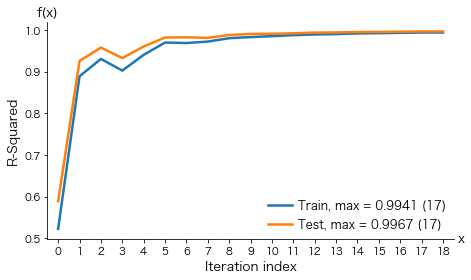

In [17]:
ax = calibr.plotting_metric("r2")

Use **`plotting_reliability()`** to plot calibration curve or so-called **reliability curve**.

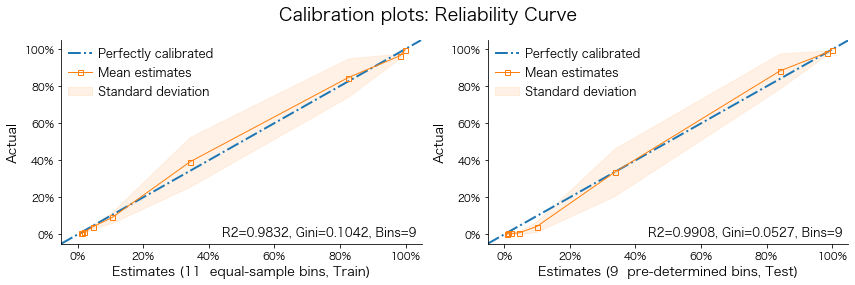

In [18]:
n_iter = 9
axes = plt.subplots(1,2,figsize=(12, 4))[1]
ax = calibr.plotting_reliability(n_iter, use_train=True , ax=axes[0], tight_layout=False)
ax = calibr.plotting_reliability(n_iter, use_train=False, ax=axes[1], tight_layout=False)
plt.gcf().suptitle('Calibration plots: Reliability Curve', fontsize=18)
plt.tight_layout()

Use **`plotting_hist()`** to enable us to compare calibrated estimates and actual percentage.

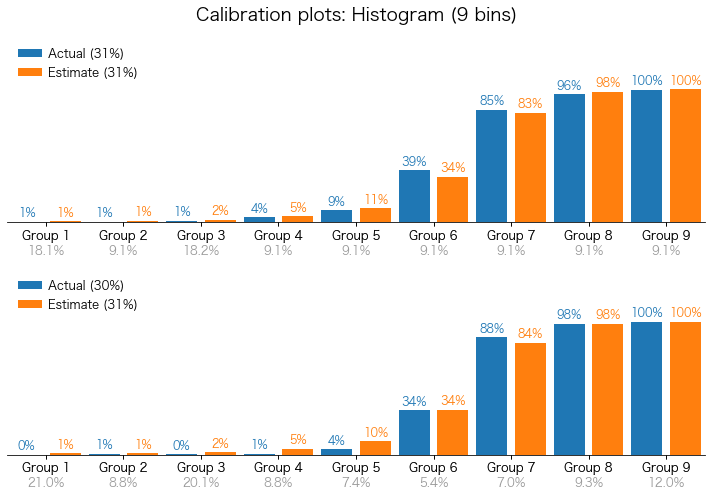

In [19]:
axes = plt.subplots(2, 1,figsize=(10,7))[1]
calibr.plotting_hist(n_iter, use_train=True , ax=axes[0], tight_layout=False)
calibr.plotting_hist(n_iter, use_train=False, ax=axes[1], tight_layout=False)
n_bins = calibr.result[n_iter].train.info.shape[0]
plt.gcf().suptitle("Calibration plots: Histogram ({:,d} bins)"
                   .format(n_bins), fontsize=18)
plt.tight_layout()

Summary table

In [20]:
calibr.result[n_iter].train.info

,r_min,r_max,p_samples,min_proba,max_proba,mean_proba,std_proba,p_targets
0,0.0000,0.0110,0.1813,0.0071,0.0110,0.0091,0.0010,0.0055
1,0.0110,0.0138,0.0913,0.0110,0.0138,0.0123,0.0008,0.0073
2,0.0138,0.0328,0.1820,0.0138,0.0328,0.0206,0.0055,0.0128
3,0.0328,0.0624,0.0907,0.0329,0.0623,0.0456,0.0085,0.0404
4,0.0624,0.1668,0.0910,0.0624,0.1666,0.1056,0.0296,0.0916
5,0.1668,0.6082,0.0910,0.1672,0.6081,0.3432,0.1340,0.3919
6,0.6082,0.9549,0.0907,0.6090,0.9546,0.8251,0.1035,0.8456
7,0.9549,0.9961,0.0910,0.9550,0.9961,0.9833,0.0117,0.9634
8,0.9961,1.0000,0.0910,0.9962,0.9999,0.9988,0.0010,0.9963


Calibrate the estimates from initial estimator.

In [21]:
z = np.round(exponent**clf.predict_proba(X_train)[:,1], deciaml) 
z = z * calibrator.coef_ + calibrator.intercept_
estimates = (1/(1 + np.exp(-z))).ravel()

Assign probabilities into groups with respect to `bin_edges`.

In [22]:
bin_edges   = calibr.result[n_iter].train.bin_edges
group_proba = np.digitize(estimates, bin_edges)

### <font color="green" size=5> Score </font>

Use **`cal_score()`** to convert probability into score.

In [23]:
p_min = 0.0001
score_kwds = dict(pdo=20, point=0, odd=p_min/(1-p_min))

In [24]:
final_group = pd.DataFrame(calibr.result[n_iter].train.info)
final_group["min_score"] = cal_score(final_group["r_min"], **score_kwds).astype(int)
final_group["max_score"] = cal_score(final_group["r_max"], **score_kwds).astype(int)
final_group["group"] = np.arange(1, len(final_group)+1)

In [25]:
final_group.set_index("group")

,r_min,r_max,p_samples,min_proba,max_proba,mean_proba,std_proba,p_targets,min_score,max_score
group,,,,,,,,,,
1,0.0000,0.0110,0.1813,0.0071,0.0110,0.0091,0.0010,0.0055,0,136
2,0.0110,0.0138,0.0913,0.0110,0.0138,0.0123,0.0008,0.0073,136,143
3,0.0138,0.0328,0.1820,0.0138,0.0328,0.0206,0.0055,0.0128,143,168
4,0.0328,0.0624,0.0907,0.0329,0.0623,0.0456,0.0085,0.0404,168,188
5,0.0624,0.1668,0.0910,0.0624,0.1666,0.1056,0.0296,0.0916,188,219
6,0.1668,0.6082,0.0910,0.1672,0.6081,0.3432,0.1340,0.3919,219,278
7,0.6082,0.9549,0.0907,0.6090,0.9546,0.8251,0.1035,0.8456,278,354
8,0.9549,0.9961,0.0910,0.9550,0.9961,0.9833,0.0117,0.9634,354,426
9,0.9961,1.0000,0.0910,0.9962,0.9999,0.9988,0.0010,0.9963,426,532
